# Map human scRNA-seq kidney on mouse Visium kidney

### 0929 - Mapping that shows patterns
- Parameter settings
```
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
    'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
    'lambda_f_reg' : 0,  # regularizer: filter values are Boolean
}
```
- It filters all cell but a single one with high probability.
- What happens if I removed the cell?
- The filters values are around 0 but are "different": maybe it is filtering?

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
fld = os.path.join(home, 'kidney_dataset')
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'human_kidney_map.h5ad')
ad_sc = sc.read_h5ad(path)
# Convert mouse genes to human convention
ad_sc.var.index = ad_sc.var.index.str.upper()
ad_sc.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'visium_mouse_kidney_filtered.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sc.var_names_make_unique()

# filter obs in ROI
mask = ad_sp.obs.in_ROI == True
ad_sp.obs = ad_sp.obs[mask]

# there are no empty voxel
sums = np.sum(ad_sp.X, axis=1).A1
assert np.sum(sums == 0) == 0

# take list of HV genes
assert ad_sc.var.highly_variable.all()
hv_genes = ad_sc.var.index.values

# Convert mouse genes to human convention
ad_sp.var.index = ad_sp.var.index.str.upper()

# Only shared genes between visium and sn
mask = ad_sp.var.index.isin(hv_genes)
ad_sp = ad_sp[:, mask]
ad_sp

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 1438 × 1654
    obs: 'in_ROI', 'frame_x', 'frame_y', 'x_fu', 'y_fu', 'x_hi', 'y_hi', 'x_lo', 'y_lo'
    var: 'gene_ids'

In [5]:
'Annotate marker genes on Visium'
mask = ad_sc.var.marker
marker_genes = ad_sc.var[mask].index.values
ad_sp.var['marker'] = ad_sp.var.index.isin(marker_genes)
ad_sp.var['marker'].sum()

Trying to set attribute `.var` of view, copying.


781

In [6]:
'Restrict ad_sc on shared genes and reindex as ad_sp'
hv_genes = ad_sp.var.index.values
mask = ad_sc.var.index.isin(hv_genes)
ad_sc = ad_sc[:, mask]
ad_sc.var = ad_sc.var.reindex(ad_sp.var.index)

***
## Feature selection

In [7]:
# 'Compute gene sparsity across datasets'
# sparsity_sc = np.sum((ad_sc.X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp.X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On HV genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [8]:
# 'Filter genes'
# # take out genes sparse in sc and not in Visium
# mask_1 = sparsity_sc > 0.9
# mask_2 = sparsity_sp < 0.5
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = mask

# # take out super sparse genes
# mask_1 = sparsity_sc > 0.97
# mask_2 = sparsity_sp > 0.97
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

# # take out genes sparse in Visium and not in sc
# mask_1 = sparsity_sc < 0.5
# mask_2 = sparsity_sp > 0.6
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

In [9]:
# sparsity_sc = np.sum((ad_sc[:, total_mask].X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp[:, total_mask].X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On ' + str(total_mask.sum()) + ' genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5); 

In [10]:
ad_sc_fl = ad_sc
ad_sp_fl = ad_sp

known_markers = [
    'CYRAB', 'NAPSA', 'NDUFB8', 'COXBA', 'HBB-BS', 'SERPINA1F'
]

[gene in list(ad_sc_fl.var.index.values) for gene in known_markers]

[False, True, False, False, False, False]

In [11]:
# sparsity_sc = np.sum(ad_sc_fl.X, axis=0) / np.sum(ad_sc.X)
# sparsity_sp = np.sum(ad_sp_fl.X.toarray(), axis=0) / np.sum(ad_sp.X)
# # plt.xscale('log')
# # plt.yscale('log')
# # plt.xlabel('Sparsity (scRNAseq)');
# # plt.ylabel('Sparsity (Visium)');
# # plt.title('On HV genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [12]:
# mask = ad_sc.var.marker
# ad_sc_marker = ad_sc[:, mask]
# mask = ad_sp.var.marker
# ad_sp_marker = ad_sp[:, mask]
# assert ad_sp_marker.var.index.equals(ad_sc_marker.var.index)

In [13]:
# sparsity_sc = np.sum((ad_sc_marker.X == 0), axis=0) / ad_sc_marker.n_obs
# sparsity_sp = np.sum((ad_sp_marker.X.toarray() == 0), axis=0) / ad_sp_marker.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On marker genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

***

In [14]:
'Allocate matrices and select device'
S = np.array(ad_sc_fl.X, dtype='float32')
G = np.array(ad_sp_fl.X.toarray(), dtype='float32')
d = np.zeros(ad_sp_fl.n_obs)
device = torch.device('cuda:0')  # for gpu

In [15]:
'Define Tangram hyperparameters'
## TODO pars not in manuscript
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
    'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
    'lambda_f_reg' : 0,  # regularizer: filter values are Boolean
}
learning_rate = 0.1
num_epochs = 6000

- Is `MapperConstrained` the same as `Mapper` w/o filter? NO: il filtro c'e' sempre negli altri terms della loss
-  Forse chiamarlo `MapperWithFilter`

In [16]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
# mapper = mapping.mapping_optimizer.Mapper(
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, 
    **hyperparm, 
#     target_count = space_data.obs.cell_count.sum()
)

#### TODO
- Save history of loss terms in mapping object.
- Plot regularizer error.

In [17]:
'Train Tangram'
# The output are the various terms in the loss function (see manuscript).
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (ie the hyperaparameter)
output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=5000)

nan 0.4127155840396881 0.07494578510522842 nan nan
nan 0.7204269766807556 0.24735775589942932 nan nan
nan 0.732366681098938 0.2667756676673889 nan nan
nan 0.7362196445465088 0.27343615889549255 nan nan
nan 0.7385908961296082 0.2764630615711212 nan nan
nan 0.7400190234184265 0.27891409397125244 nan nan
nan 0.7410695552825928 0.28100451827049255 nan nan
nan 0.7412821650505066 0.2834372818470001 nan nan
nan 0.7404575943946838 0.2871656119823456 nan nan
nan 0.735547661781311 0.29686135053634644 nan nan
nan 0.7225663065910339 0.3319770395755768 nan nan
nan 0.7280581593513489 0.34458619356155396 nan nan
nan 0.7346175312995911 0.34619927406311035 nan nan
nan 0.7377268671989441 0.3475518822669983 nan nan
nan 0.7393261194229126 0.3476286828517914 nan nan
nan 0.7405966520309448 0.3476640582084656 nan nan
nan 0.741441547870636 0.34829390048980713 nan nan
nan 0.7424107193946838 0.3483634293079376 nan nan
nan 0.7432854771614075 0.3486485183238983 nan nan
nan 0.7441300749778748 0.3487206697463989 na

**Tommaso** I get 0.756 and 0.349 cosine similarities.

***
## Filter analysis

#### TODO 
- Filter analysis: how many cells have been mapped? 
- What are the cell type proportions?

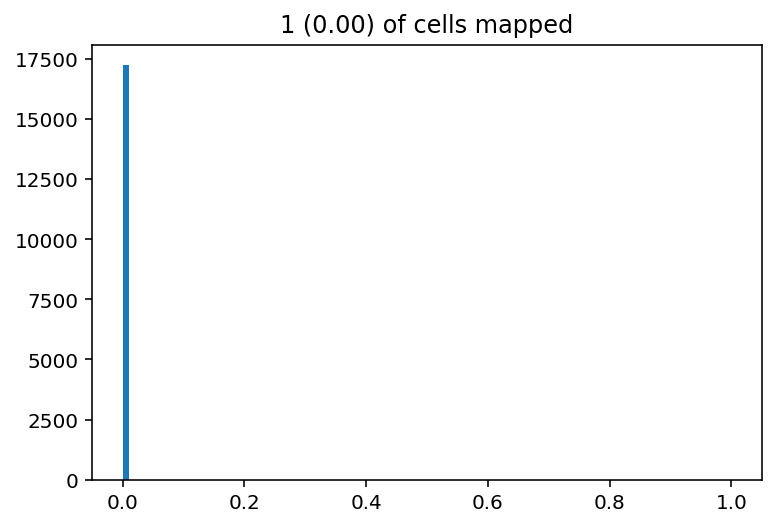

In [54]:
# all cells are mapped to "zero" except a single one
n_mapped_cells = np.sum(F_out > .5)
pct_mapped_cells =  n_mapped_cells / len(F_out)
plt.title('{:d} ({:.2f}) of cells mapped'.format(n_mapped_cells, pct_mapped_cells))
plt.hist(F_out, bins=100);

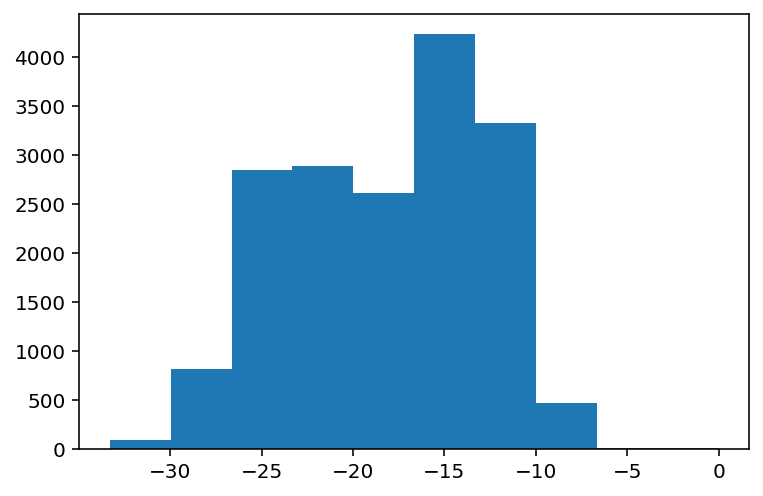

In [55]:
# Although log structure shows that the filter is doing something
plt.hist(np.log(F_out));

In [57]:
np.log(1e-9)

-20.72326583694641

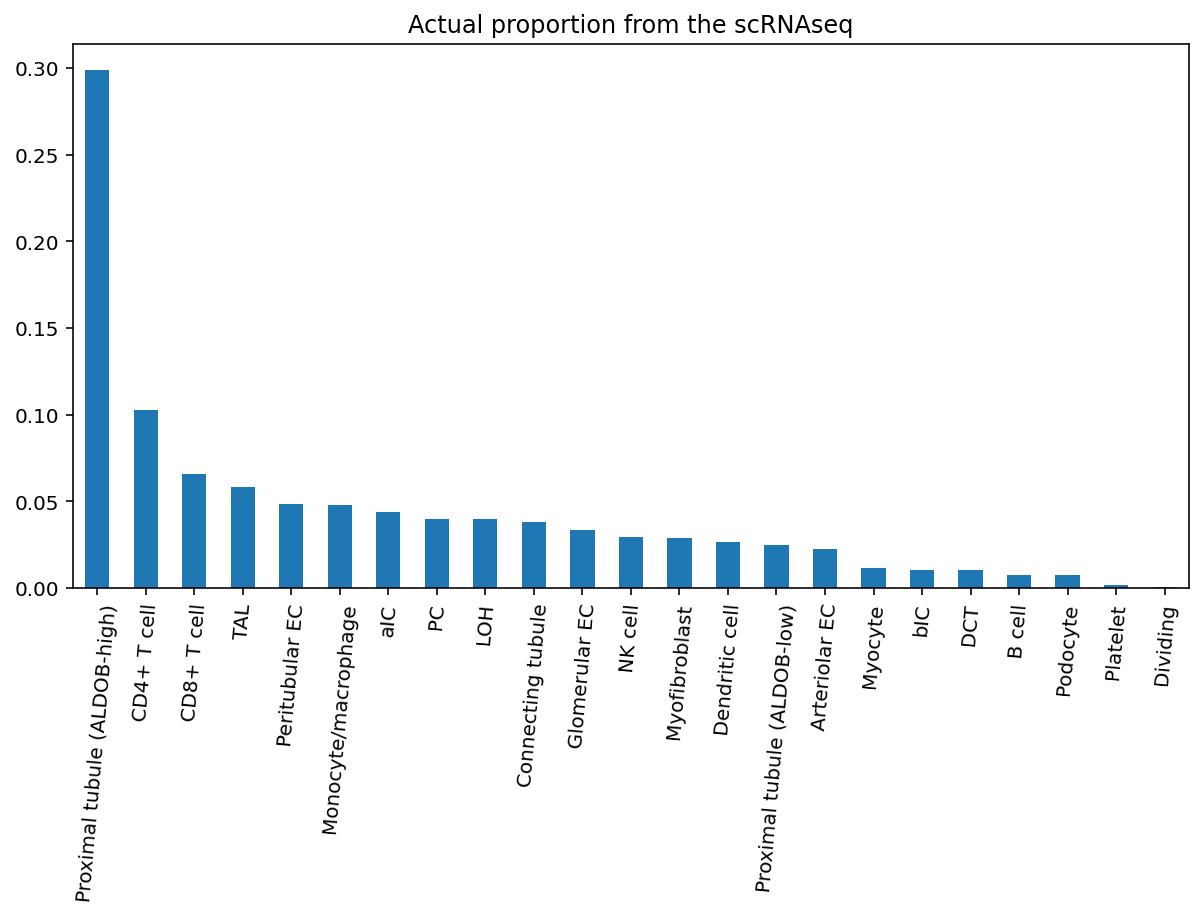

In [56]:
fracs = ad_sc.obs['subsampling.label'].value_counts() / ad_sc.n_obs
fracs.plot(kind='bar', rot=85, figsize=(10, 5));
plt.title('Actual proportion from the scRNAseq');

In [61]:
# 64% of cells are mapped with filter weight higher than 1e-9
np.sum(F_out > 1e-9) / len(F_out)

0.6479967530585029

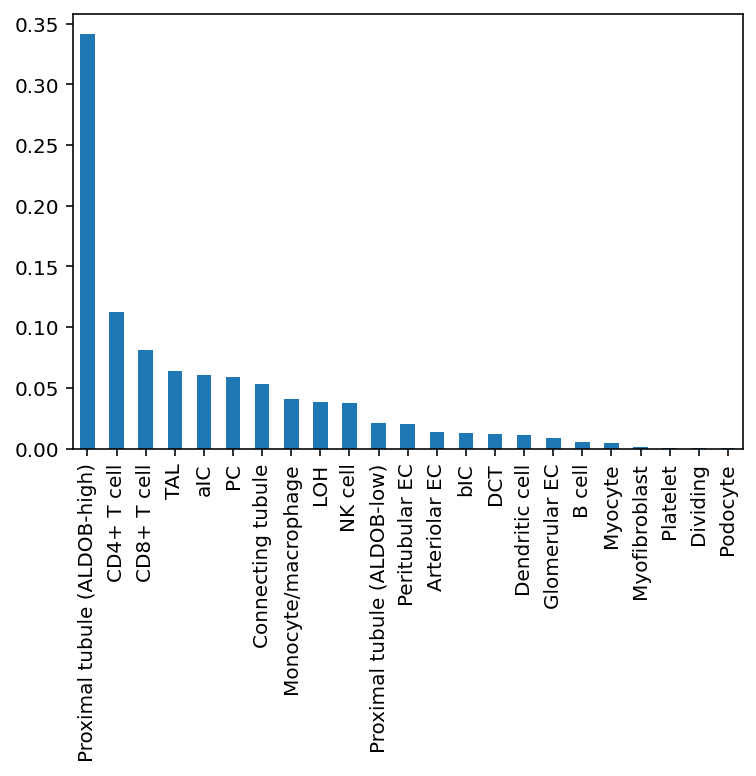

In [62]:
'Proportion of mapped cells'
mask = F_out > 1e-9 
fracs_2 = ad_sc[mask, :].obs['subsampling.label'].value_counts() / ad_sc[mask, :].n_obs
fracs_2.plot(kind='bar');

***

#### TODO
- Transfer annotation can be part of mapping object, given that

In [63]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(ad_sc_fl.obs['subsampling.label'])
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

,Myofibroblast,Podocyte,LOH,Monocyte/macrophage,Dendritic cell,TAL,NK cell,Arteriolar EC,Peritubular EC,Glomerular EC,...,Myocyte,aIC,CD8+ T cell,Proximal tubule (ALDOB-high),DCT,B cell,bIC,CD4+ T cell,PC,Dividing
0,1.827007e-11,1.045478e-12,0.000127,1.824319e-08,1.698301e-09,0.000002,0.000082,5.467440e-10,1.469049e-09,0.000207,...,1.164294e-11,0.000402,0.000002,0.000025,0.000089,5.162467e-05,6.185451e-07,2.754725e-07,0.000101,2.968530e-15
1,3.618281e-11,6.927971e-13,0.000151,2.712064e-08,1.798943e-09,0.000006,0.000062,7.821485e-10,3.784206e-10,0.000159,...,1.036362e-10,0.000333,0.000007,0.000030,0.000167,6.630941e-08,5.933881e-07,3.255432e-06,0.000244,3.032145e-15
2,2.702282e-11,7.794769e-14,0.000297,1.205040e-07,8.288257e-09,0.000006,0.000342,3.531205e-09,5.332960e-09,0.000173,...,6.690855e-09,0.001620,0.000004,0.000056,0.000205,4.133785e-04,3.732498e-06,3.936223e-06,0.000210,4.606896e-11
3,1.084397e-11,4.735239e-12,0.000155,6.637584e-08,9.019519e-10,0.000004,0.000032,1.268442e-09,1.071695e-09,0.000072,...,8.723127e-09,0.000181,0.000004,0.000040,0.000300,5.679415e-06,1.576458e-06,1.254053e-06,0.000093,6.695677e-14
4,1.508946e-11,6.257318e-12,0.000243,1.878252e-07,6.056192e-09,0.000012,0.000351,1.162366e-09,6.945972e-09,0.000424,...,3.144180e-08,0.001311,0.000007,0.000058,0.000294,1.317413e-04,2.076511e-06,1.002598e-05,0.000388,5.207259e-15


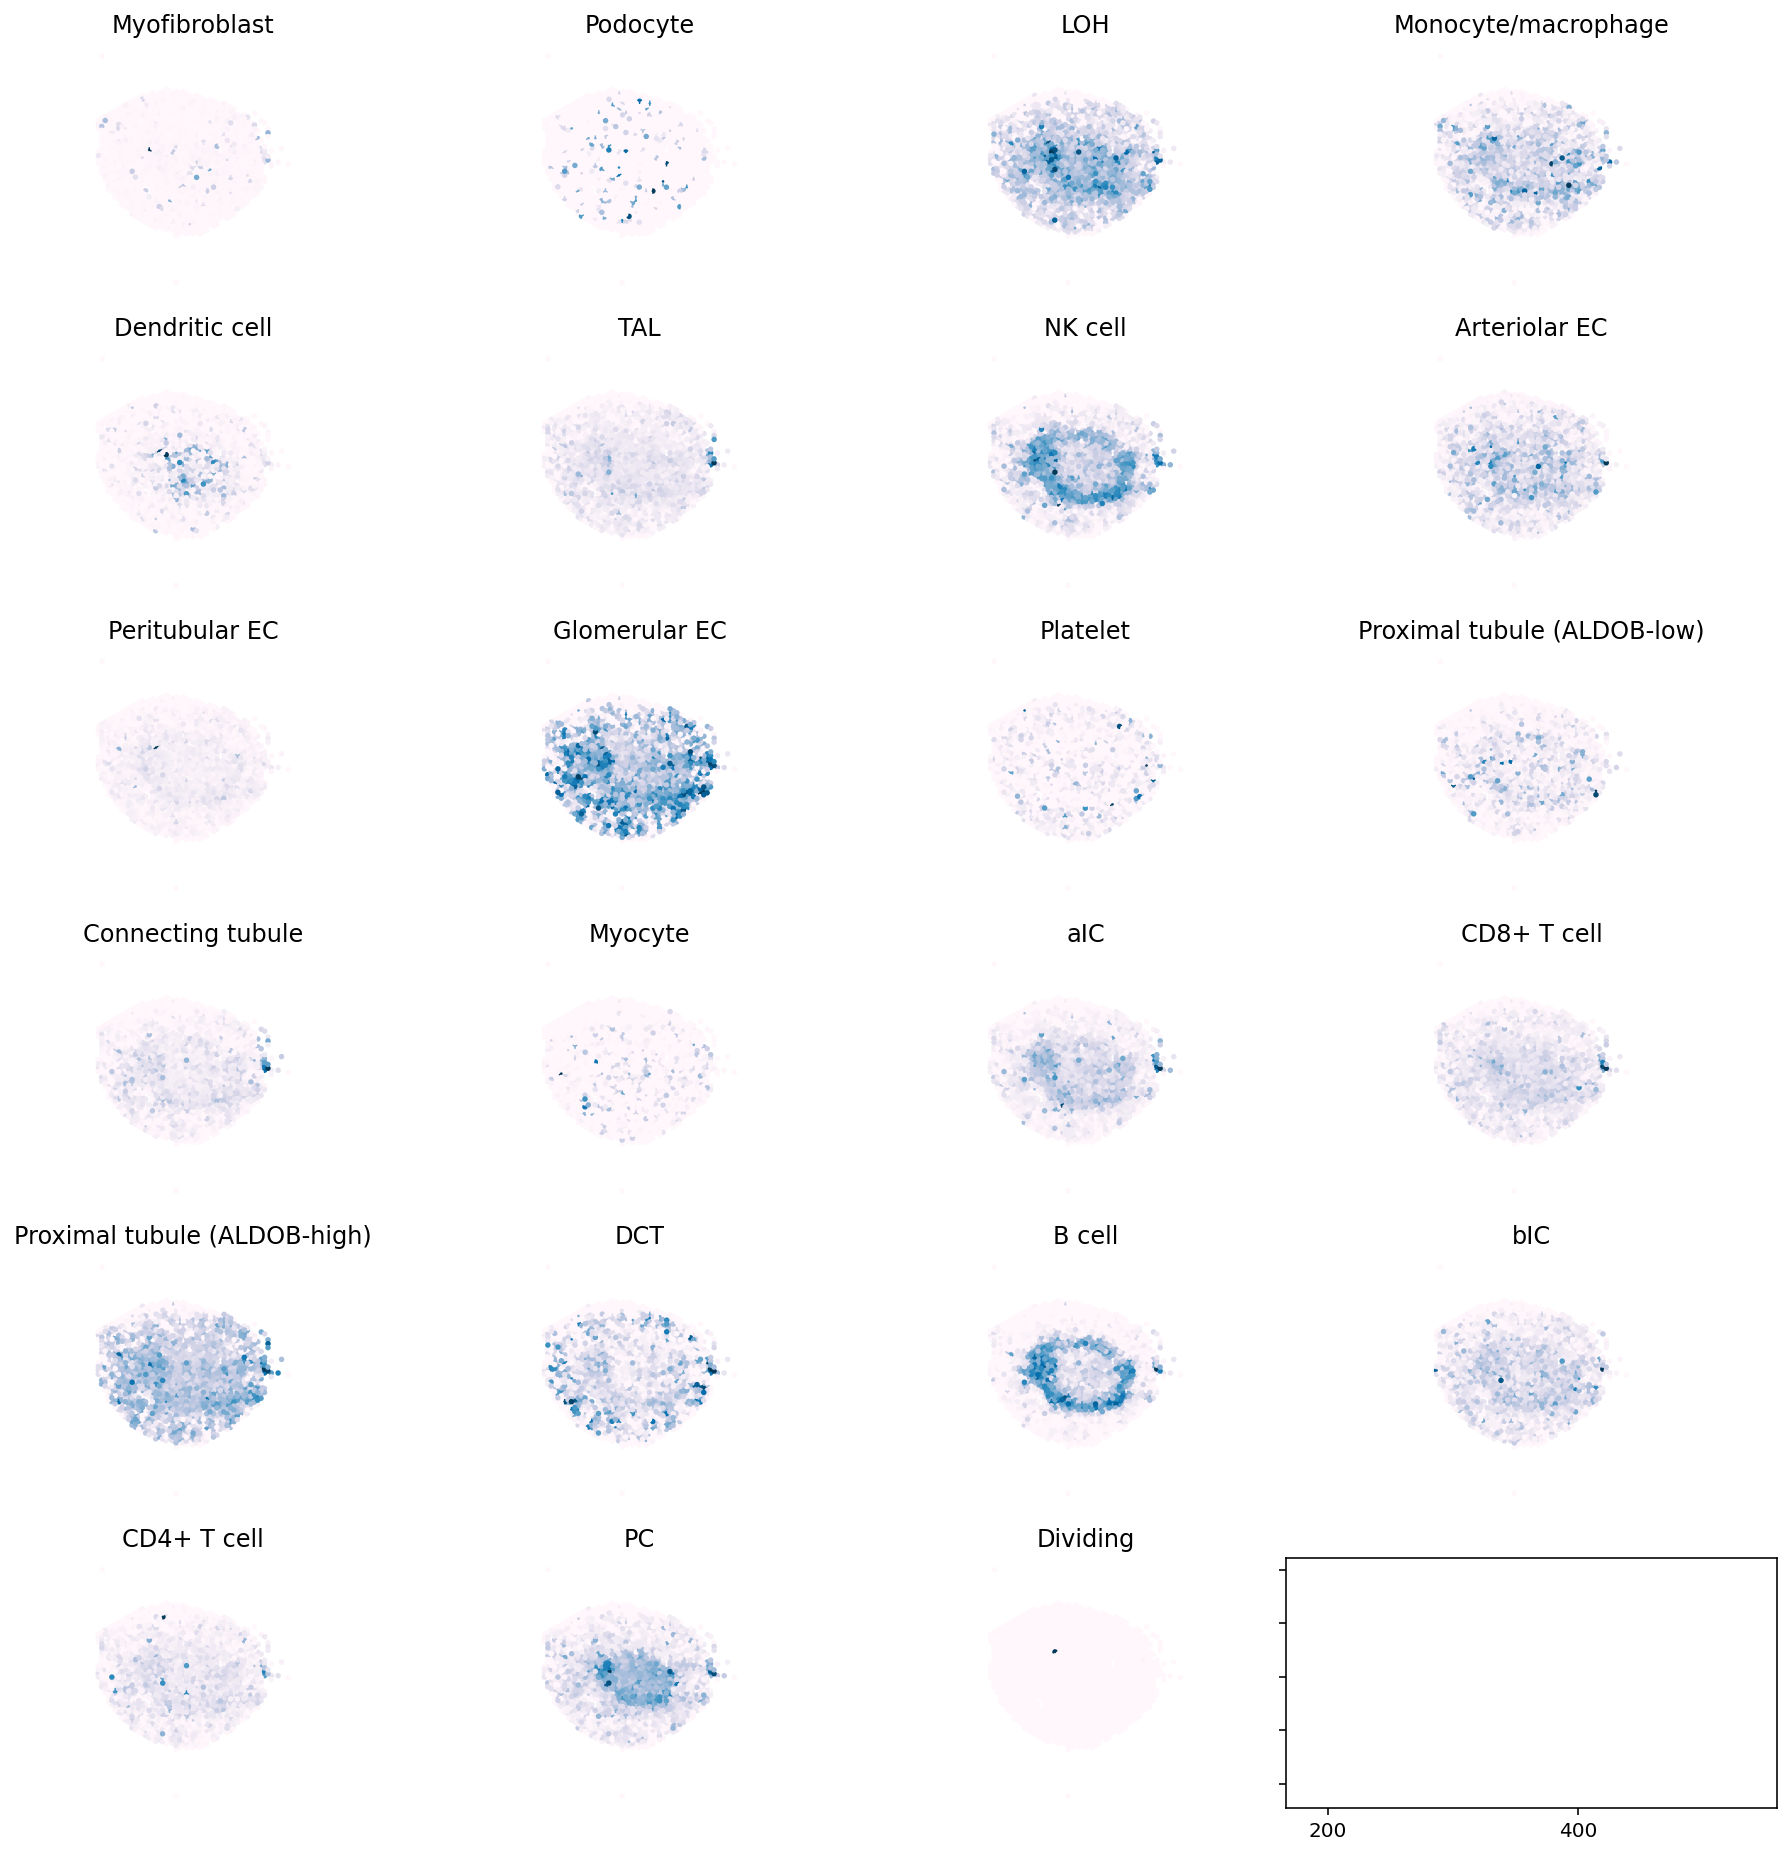

In [64]:
# compute cell type list
cell_types = list(ad_sc.obs['subsampling.label'].unique())

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(13, 13), sharex=True, sharey=True)
for ax, ct in zip(axs.flatten(), cell_types):
    ax.scatter(x=ad_sp.obs.x_lo, # gene profile of ad_sp doesn't matter
               y=ad_sp.obs.y_lo, 
               c=prob_assign[ct], 
               s=3, 
               cmap='PuBu');
    ax.set_title(ct)
    ax.set_aspect(1)
    ax.axis('off');
plt.tight_layout()